# EEG Preprocessing with MNE

In [1]:
import pandas as pd
import numpy as np
import mne
from mne.io import RawArray
import matplotlib.pyplot as plt
import mne.channels as ch
from scipy.signal import butter, lfilter
from joblib import Parallel, delayed
from os import listdir

### Load raw EEG and events from csv
Using just one file for testing

In [2]:
FILE = "data_clean/Subject_a_test.csv"
data = pd.read_csv(FILE)

In [29]:
col_names = data.columns
data.shape
data.head(5)

,AF3,AF4,F5,F3,F1,Fz,F2,F4,F6,FC5,...,Pz,P2,P4,P6,PO1,PO2,O1,O2,left,foot
0,-11.2,-11.1,5.0,1.0,-7.2,5.3,-12.6,10.3,-13.5,-3.8,...,12.6,44.5,0.0,-3.0,-8.2,-16.2,8.9,-26.6,0.0,1.0
1,-8.3,-8.7,13.3,5.1,-3.6,7.2,-9.8,11.0,-13.8,4.9,...,13.6,44.8,1.8,-0.1,-6.3,-14.8,9.4,-25.3,0.0,1.0
2,-8.5,-9.1,12.7,4.3,-3.8,6.6,-10.2,11.5,-14.7,2.5,...,13.1,44.7,3.3,-0.7,-6.7,-16.4,8.5,-24.7,0.0,1.0
3,-12.2,-12.0,3.1,-1.0,-8.9,4.1,-12.9,10.5,-15.2,-10.2,...,11.5,43.8,2.2,-2.2,-9.2,-18.6,6.4,-25.1,0.0,1.0
4,-17.6,-16.6,-4.3,-6.3,-14.8,-0.4,-17.3,6.1,-18.6,-18.3,...,8.7,40.8,-1.7,-4.6,-13.0,-21.4,1.6,-28.6,0.0,1.0


In [4]:
#store channel names
channels = list(data.columns[:-2])
print(channels)

['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']


In [5]:
raw = np.array(data).T
raw.shape

(61, 428939)

In [6]:
len(data.columns)

61

In [7]:
#create metadata
n_channels = len(data.columns)
eeg_channels = len(channels)
sampling = 1000 #Hz
channel_types = ['eeg']*eeg_channels
channel_types.extend(['stim']*2)
montage = 'standard_1005'

info = mne.create_info(list(data.columns), sampling, channel_types)
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG, 2 STIM
 custom_ref_applied: False
 dig: 62 items (3 Cardinal, 59 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 61
 projs: []
 sfreq: 1000.0 Hz
>

In [8]:
raw = RawArray(raw,info,verbose=False)

## Actual preprocessing
#### Filtering

In [10]:
#get EEEG channels only
picks = mne.pick_types(raw.info,eeg=True)

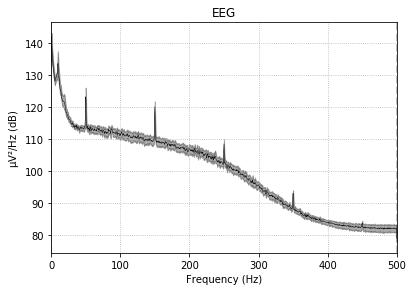

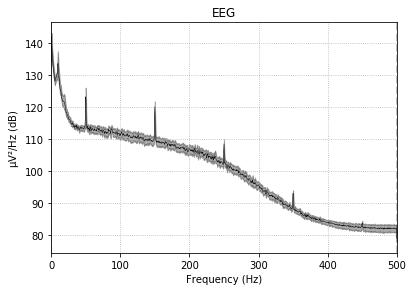

In [77]:
#check spectral power to see power line noise
raw.plot_psd(fmax=500, picks=picks, average=True)

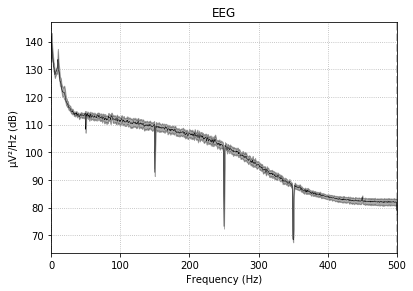

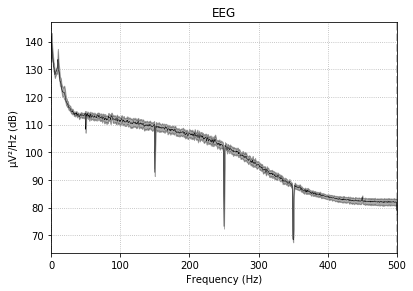

In [11]:
#filter out power line noise
#we can see peaks at 50, 150, 250 and 350
freqs = (50, 150, 250, 350)
raw_notch = raw.copy().notch_filter(freqs=freqs, picks=picks)

#plot to compare
raw_notch.plot_psd(fmax=500, picks=picks, average=True)

In [12]:
#butterworth bandpass filter with 7 and 30 Hz
freqs = [7, 30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')
clean = raw_notch.copy()

In [14]:
clean._data[picks] = np.array(Parallel(n_jobs=1)(delayed(lfilter)(b,a,clean._data[i]) for i in picks))

In [31]:
final = pd.DataFrame(data=clean._data.T, columns=col_names)

,AF3,AF4,F5,F3,F1,Fz,F2,F4,F6,FC5,...,Pz,P2,P4,P6,PO1,PO2,O1,O2,left,foot
85783,-4.211823,-4.492394,-3.397657,-4.779451,-5.098258,-4.961722,-5.077097,-4.987418,-5.392736,-1.805718,...,-4.423120,-3.682279,-2.801016,-2.870273,-1.542073,NaN,NaN,NaN,0.0,1.0
85784,1.512403,1.220851,2.598370,2.567131,1.807564,1.360638,0.931165,0.092302,-0.277935,3.826600,...,1.897119,4.157984,4.954014,4.129151,1.882938,NaN,NaN,NaN,0.0,1.0
85785,10.877834,8.883584,11.187041,12.073269,11.546538,11.189281,10.564534,8.812803,8.056130,10.009948,...,11.635625,13.799523,13.148337,11.310616,7.706016,NaN,NaN,NaN,0.0,1.0
85786,9.698898,8.096977,9.720693,10.750405,11.099388,10.959980,10.147711,8.901657,7.390922,8.851654,...,12.393325,13.400066,13.057207,11.327813,6.955827,NaN,NaN,NaN,0.0,1.0
85787,0.279259,1.168601,1.006000,1.891720,1.466133,1.136451,1.166343,0.734724,-0.130577,2.217606,...,3.243115,3.996269,5.358054,4.843188,-0.761357,NaN,NaN,NaN,NaN,1.0


In [142]:
final.to_csv("final_data/s.csv", index=False)

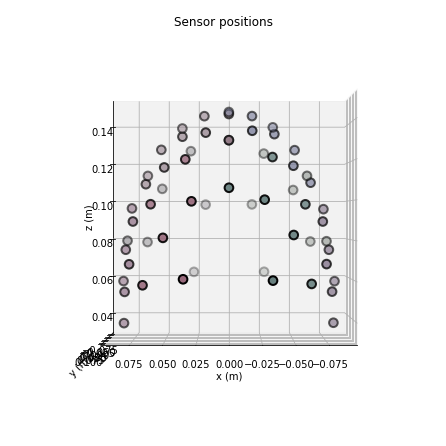

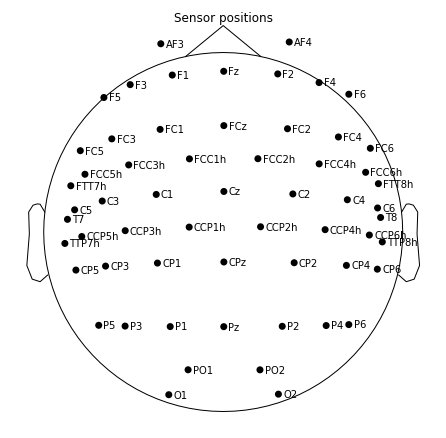

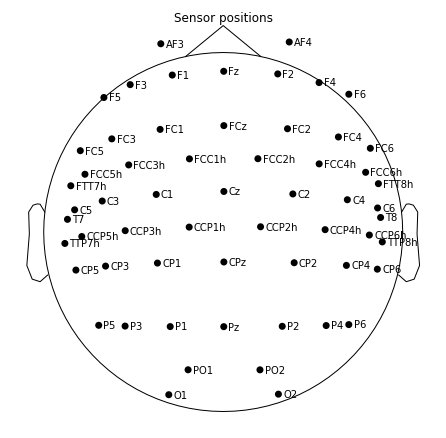

In [66]:
raw.plot_sensors(ch_type='eeg',kind="3d",title="Sensor positions",ch_groups="position")
raw.plot_sensors(ch_type='eeg',title="Sensor positions",show_names=True,to_sphere=False)

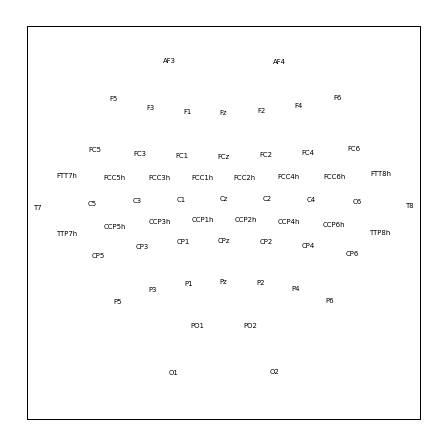

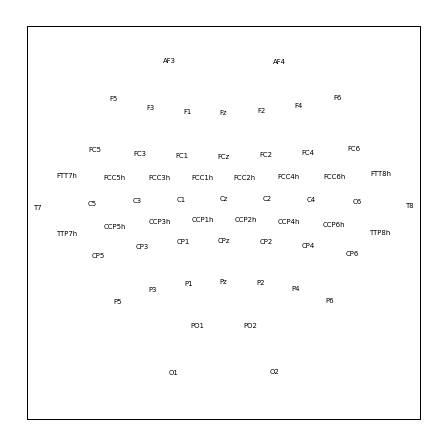

In [58]:
layout= ch.make_eeg_layout(raw.info)
layout.plot()

## Code assemble

In [34]:
files = []
for f in listdir("data_clean"):
    if f.endswith(".csv"):
        files.append(f)

freqs = [7, 30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')

Processing Subject_a_test.csv


In [30]:
for f in files:
    print("Processing {}" .format(f))
    fname = os.path.join("data_clean",f)
    data = pd.read_csv(fname)
    print("Loaded")
    col_names = data.columns
    channels = list(data.columns[:-2])
    raw = np.array(data).T

    n_channels = len(data.columns)
    eeg_channels = len(channels)
    sampling = 1000 #Hz
    channel_types = ['eeg']*eeg_channels
    channel_types.extend(['stim']*2)
    montage = 'standard_1005'

    info = mne.create_info(list(data.columns), sampling, channel_types)
    info.set_montage(montage)

    raw = RawArray(raw,info,verbose=False)
    print("assembled")

    picks = mne.pick_types(raw.info,eeg=True)
    freqs = (50, 150, 250, 350)
    raw = raw.notch_filter(freqs=freqs, picks=picks)

    raw._data[picks] = np.array(Parallel(n_jobs=1)(delayed(lfilter)(b,a,raw._data[i]) for i in picks))
    print("filtered")

    final = pd.DataFrame(data=raw._data.T, columns=col_names)

    save_to = os.path.join("final_data",f)
    final.to_csv(save_to, index=False)

Loaded
assembled
filtered


OSError: [Errno 28] No space left on device